## Setup

In [1]:
# install some packages
!pip install sseclient mmh3 bitarray 

In [1]:
# import required libraries
import math
import re

from BloomFilter import BloomFilter
import matplotlib.pyplot as plt
import mmh3
import pandas as pd
import seaborn as sns
from bitarray import bitarray
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    abs,
    avg,
    col,
    count,
    explode,
    from_json,
    hour,
    length,
    log,
    log10,
    lower,
    regexp_extract_all,
    regexp_replace,
    size,
    split,
    to_date,
    to_timestamp,
    udf,
    when,
)
from pyspark.sql.types import (
    ArrayType,
    BooleanType,
    IntegerType,
    LongType,
    StringType,
    StructField,
    StructType,
)

In [2]:
# get UA/EN stop words
import nltk
from nltk.corpus import stopwords as nltk_stopwords

nltk.download("stopwords")
stop_words = list(nltk_stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmytro.miedviediev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import sampled data using Spark

In [3]:
spark = SparkSession.builder.appName("WikipediaBotFilterEDA").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/19 09:23:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# define data schema
schema = StructType(
    [
        StructField("id", LongType(), True),
        StructField("title", StringType(), True),
        StructField("user", StringType(), True),
        StructField("bot", BooleanType(), True),
        StructField("length", IntegerType(), True),
        StructField("wiki", StringType(), True),
        StructField("timestamp", StringType(), True),
        StructField("minor", BooleanType(), True),
        StructField("comment", StringType(), True),
    ]
)

# read sampled data from store
df = spark.read.csv(
    path="/Users/dmytro.miedviediev/Projects/MMDS/hw2/sample_data/*.csv",
    header=False,
    schema=schema,
)

# print sample
df.printSchema()
df.show(5)

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user: string (nullable = true)
 |-- bot: boolean (nullable = true)
 |-- length: integer (nullable = true)
 |-- wiki: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- minor: boolean (nullable = true)
 |-- comment: string (nullable = true)

+----------+--------------------+--------------+-----+------+------+-------------------+-----+--------------------+
|        id|               title|          user|  bot|length|  wiki|          timestamp|minor|             comment|
+----------+--------------------+--------------+-----+------+------+-------------------+-----+--------------------+
|1833392203|          Kastolatsi|       Monkbot| true|     1|enwiki|2024-10-27 02:55:35| true|[[User:Monkbot/ta...|
|1833392304|1981 Golbaf earth...|Dawnseeker2000|false|   -27|enwiki|2024-10-27 02:55:48| true|[[WP:AWB/T|Typo f...|
|1833392603|     Lebanese Arabic| 70.83.137.110|false|    -8|enwiki|2024-10-27 0

## EDA

According to the task, we imagine that we need to create system to filter out bots. So, we don't have "bot" column.

Now, let's suppose that we have manually labeled our sampled dataset (to make such system) and now have ground truth "bot" column.

Also, we don't have to use user column for prediction (according to the constraints).

In [5]:
# convert timestamp & date to timestamp & date type
df = df.withColumn("timestamp", to_timestamp("timestamp"))
df = df.withColumn("timestamp", (col("timestamp")).cast("timestamp"))
df = df.withColumn("date", to_date("timestamp"))
# fill missing values
df = df.fillna({"length": 0, "bot": False, "comment": ""})
# adjust lenght columns
df = df.withColumn("length", abs(col("length")))
# cast fields
df = df.withColumn("comment", col("comment").cast("string"))
df = df.withColumn("user", col("user").cast("string"))

In [6]:
# define separate variables for humans & bots
bot_df = df.filter(col("bot") == True)
human_df = df.filter(col("bot") == False)

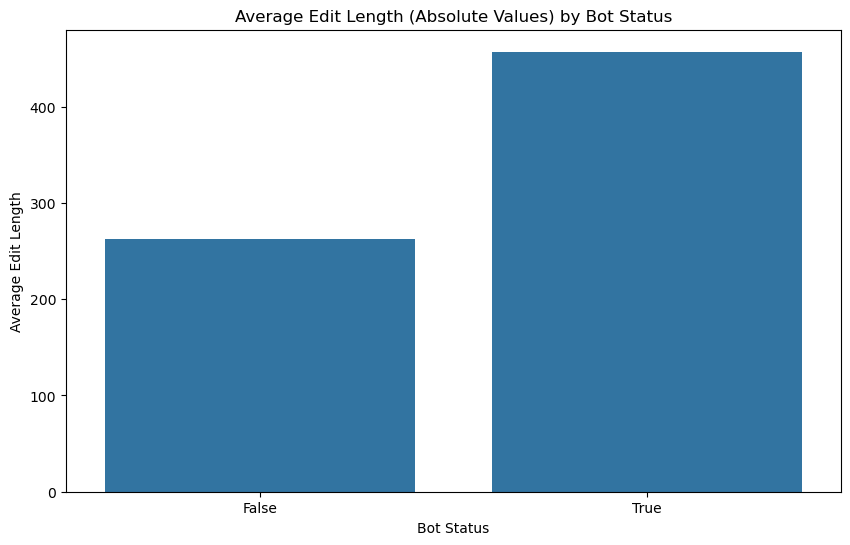

In [7]:
# average edit lenght
avg_length_df = df.groupBy("bot").agg(avg("length").alias("avg_length"))
avg_length_pandas_df = avg_length_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_length_pandas_df, x="bot", y="avg_length")
plt.title("Average Edit Length (Absolute Values) by Bot Status")
plt.xlabel("Bot Status")
plt.ylabel("Average Edit Length")
plt.show()

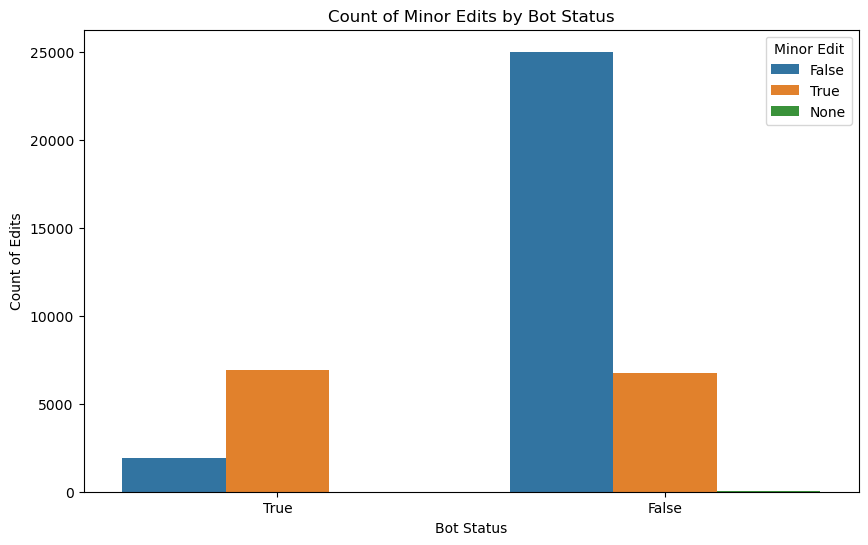

In [8]:
# count of minor edits for each bot status
minor_counts_df = df.groupBy("bot", "minor").agg(count("*").alias("count"))
minor_counts_pandas_df = minor_counts_df.toPandas()
minor_counts_pandas_df["bot"] = minor_counts_pandas_df["bot"].astype(str)
minor_counts_pandas_df["minor"] = minor_counts_pandas_df["minor"].astype(str)

plt.figure(figsize=(10, 6))
sns.barplot(data=minor_counts_pandas_df, x="bot", y="count", hue="minor")
plt.title("Count of Minor Edits by Bot Status")
plt.xlabel("Bot Status")
plt.ylabel("Count of Edits")
plt.legend(title="Minor Edit")
plt.show()

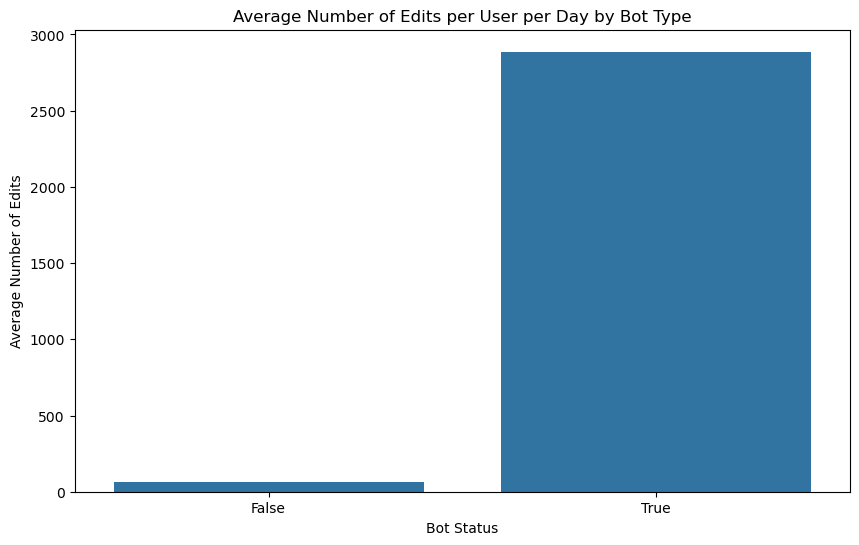

In [9]:
# average number of edits per user per day by bot type
user_date_edits = df.groupBy("user", "date").agg(count("*").alias("user_edits"))
df_edits = df.join(user_date_edits, on=["user", "date"])
avg_edits_by_bot = df_edits.groupBy("bot").agg(
    avg("user_edits").alias("avg_user_edits")
)
avg_edits_by_bot_pandas = avg_edits_by_bot.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_edits_by_bot_pandas, x="bot", y="avg_user_edits")
plt.title("Average Number of Edits per User per Day by Bot Type")
plt.xlabel("Bot Status")
plt.ylabel("Average Number of Edits")
plt.show()

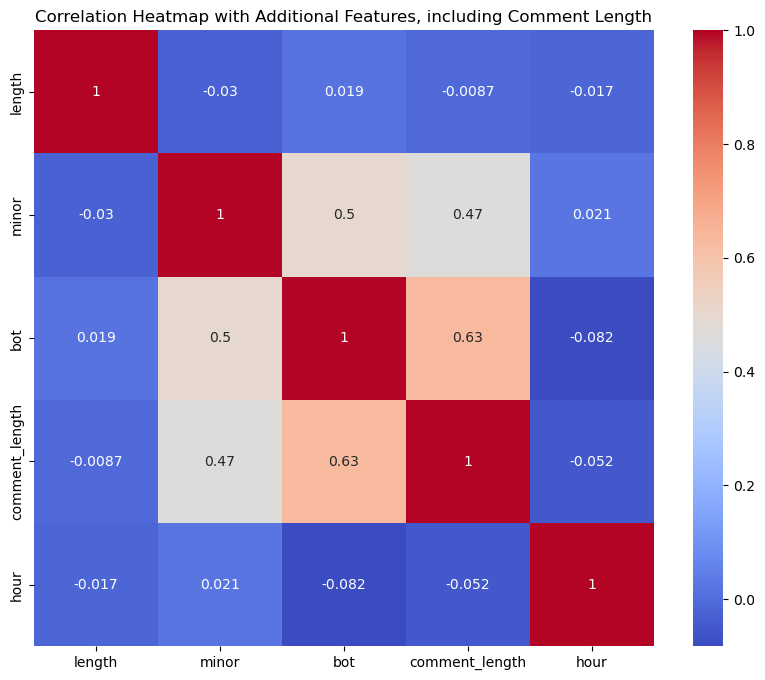

In [10]:
df = df.withColumn("comment_length", length(col("comment")))

# Add comment_length to the numerical features list
numerical_features = ["length", "minor", "bot", "comment_length"]

# Include derived features like the hour from timestamp
df = df.withColumn("hour", hour("timestamp"))
numerical_features.append("hour")

# Extract numerical features and convert to Pandas
numerical_df = df.select(numerical_features).toPandas()

# Plot correlation heatmap with additional features
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap with Additional Features, including Comment Length")
plt.show()

Let's work with the "comments" column as it can show us how to find out bots.

In [11]:
sampled_comments = (
    df.filter(df["bot"] == True).select("comment").sample(fraction=0.1).limit(20)
)
for row in sampled_comments.collect():
    print(row["comment"])

Moving [[:Category:Songwriter unknown]] to [[:Category:Songs with unknown songwriters]] per [[Wikipedia:Categories for discussion/Log/2024 October 19#Category:Songwriter unknown]]
updated mostrefs log - location 1022
[[User:Monkbot/task 20|Task 20]]: replace {lang-??} templates with {langx|??} [[Wikipedia:Templates_for_discussion/Log/2024_September_27#Replace_and_delete_lang-??_templates|‹See Tfd›]] (Replaced 1);
Moving [[:Category:Songwriter unknown]] to [[:Category:Songs with unknown songwriters]] per [[Wikipedia:Categories for discussion/Log/2024 October 19#Category:Songwriter unknown]]
Moving [[:Category:Songwriter unknown]] to [[:Category:Songs with unknown songwriters]] per [[Wikipedia:Categories for discussion/Log/2024 October 19#Category:Songwriter unknown]]
Moving [[:Category:Songwriter unknown]] to [[:Category:Songs with unknown songwriters]] per [[Wikipedia:Categories for discussion/Log/2024 October 19#Category:Songwriter unknown]]
[[User:Monkbot/task 20|Task 20]]: replace {

In [12]:
sampled_comments_human = (
    df.filter(df["bot"] == False).select("comment").sample(fraction=0.1).limit(20)
)
for row in sampled_comments_human.collect():
    print(row["comment"])

/* 2020s */
removed [[Category:Ovalentaria]]; added [[Category:Cichliformes]] using [[WP:HC|HotCat]]
added [[Category:1926 elections]] using [[WP:HC|HotCat]]
[[WP:AES|←]]Changed redirect target from [[Abdul Hamid II#Hamidian Era]] to [[Hamidian Period]]
added [[Category:1920s Ohio elections]] using [[WP:HC|HotCat]]

[[Wikipedia talk:Criteria for speedy deletion/Archive 9#IP talk pages|blank ancient IP talk page messages]]
Fixed grammar
Neville George Clevely Heath was a British serial killer who has his own Wiki article.
/* Listing of all current petitions? */ reply
/* top */ [[Wikipedia talk:Criteria for speedy deletion/Archive 9#IP talk pages|blank ancient IP talk page messages]]

/* Handlung */ Formulierung
[[Wikipedia talk:Criteria for speedy deletion/Archive 9#IP talk pages|blank ancient IP talk page messages]]
Do we really need this long excerpt?  Isn't it Wikisource's job?
Adding local [[Wikipedia:Short description|short description]]: "English actor and producer" overriding Wik

In [13]:
def preprocess_text(text):
    text = text.lower()
    words = re.findall(r"\b\w+\b", text, re.UNICODE)
    words = [word for word in words if word not in stop_words]
    return words


preprocess_text_udf = udf(preprocess_text, ArrayType(StringType()))

bot_comments = bot_df.select("comment").na.drop()
bot_comments = bot_comments.withColumn("words", preprocess_text_udf(col("comment")))
bot_words = bot_comments.select(explode(col("words")).alias("word"))
bot_word_counts = bot_words.groupBy("word").count().orderBy(col("count").desc())

human_comments = human_df.select("comment").na.drop()
human_comments = human_comments.withColumn("words", preprocess_text_udf(col("comment")))
human_words = human_comments.select(explode(col("words")).alias("word"))
human_word_counts = human_words.groupBy("word").count().orderBy(col("count").desc())

print("Top 20 words in bot comments:")
bot_word_counts.show(20)

# Display top 20 words for humans
print("\nTop 20 words in human comments:")
human_word_counts.show(20)

Top 20 words in bot comments:


+--------------------+-----+
|                word|count|
+--------------------+-----+
|                task|10257|
|                  20|10166|
|                user| 6170|
|                 log| 5886|
|           templates| 5718|
|           wikipedia| 5534|
|                 see| 5137|
|                lang| 5100|
|            replaced| 5079|
|                 tfd| 5075|
|          _templates| 5075|
|replace_and_delet...| 5075|
|   2024_september_27| 5075|
|             monkbot| 5075|
|               langx| 5075|
|             replace| 5075|
|templates_for_dis...| 5075|
|                   1| 4327|
|                 bot| 1510|
|                   2| 1188|
+--------------------+-----+
only showing top 20 rows


Top 20 words in human comments:
+-------------+-----+
|         word|count|
+-------------+-----+
|           wp| 4477|
|         talk| 2128|
|        added| 1933|
|     category| 1676|
|      special| 1550|
|         user| 1464|
|    wikipedia| 1174|
|        using| 1152|
|  

## Modelling

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import (
    IDF,
    HashingTF,
    StopWordsRemover,
    Tokenizer,
    VectorAssembler,
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, length, when

# drop columns that could be created during EDA
df = df.drop("words", "filtered_words", "raw_features", "features")


# engineer feature from EDA insights
df = df.withColumn(
    "comment_length", when(col("comment").isNull(), 0).otherwise(length(col("comment")))
)
df = df.withColumn("label", col("bot").cast("double"))
df = df.fillna(
    {"length": 0, "comment_length": 0, "minor": False, "bot": False, "comment": ""}
)


# split data for training/testing
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)


# collect pipeline parts
tokenizer = Tokenizer(inputCol="comment", outputCol="tokenized_words")
remover = StopWordsRemover(
    inputCol="tokenized_words",
    outputCol="filtered_words",
    stopWords=stop_words,
    locale="en_US",
)
hashing_tf = HashingTF(
    inputCol="filtered_words", outputCol="raw_features", numFeatures=600
)
idf = IDF(inputCol="raw_features", outputCol="text_features")
assembler = VectorAssembler(
    inputCols=["text_features", "minor", "comment_length"], outputCol="features"
)
lr = LogisticRegression(featuresCol="features", labelCol="label")


# create pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashing_tf, idf, assembler, lr])


# configure grid search
param_grid = (
    ParamGridBuilder()
    .addGrid(hashing_tf.numFeatures, [300, 500, 600, 1000])
    .addGrid(lr.regParam, [0.01, 0.1, 1.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build()
)


# configure evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)


# configure cross-validation
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2,
)


# run cross validation with grid search
cv_model = crossval.fit(train_data)


# save best model
model_save_path = "/Users/dmytro.miedviediev/Projects/MMDS/hw2/model/"
best_model = cv_model.bestModel
best_model.write().overwrite().save(model_save_path)

# print model params
print("\nBest Model Parameters:")
print(f"HashingTF numFeatures: {best_model.stages[2]._java_obj.getNumFeatures()}")
print(f"LogisticRegression regParam: {best_model.stages[5]._java_obj.getRegParam()}")
print(
    f"LogisticRegression elasticNetParam: {best_model.stages[5]._java_obj.getElasticNetParam()}"
)


# predict on test data
predictions = best_model.transform(test_data)


# evaluate best model
recall = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
).evaluate(predictions)

precision = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
).evaluate(predictions)

f1 = evaluator.evaluate(predictions)


# print evaluation results
print(f"Bot Prediction Recall: {recall:.2f}")
print(f"Bot Prediction Precision: {precision:.2f}")
print(f"Bot Prediction F1-score: {f1:.2f}")

predictions.groupBy("label", "prediction").count().show()


Best Model Parameters:
HashingTF numFeatures: 1000
LogisticRegression regParam: 0.01
LogisticRegression elasticNetParam: 0.0
Bot Prediction Recall: 0.99
Bot Prediction Precision: 0.99
Bot Prediction F1-score: 0.99
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2491|
|  0.0|       1.0|   35|
|  1.0|       0.0|   83|
|  0.0|       0.0| 9426|
+-----+----------+-----+


In [33]:
# as in this dataset we have ground truth labels (we need them to train model), we can use ground truth labels for our bloom filter
bot_user_identifiers = df.filter(col("bot") == True).select("user").distinct().collect()
len(bot_user_identifiers)

86

**Summary**

We have used 40k of sampled records to label them (theoretically) and train basic Logistic Regression model. We don't want to make it over engineered and use some more complicated methods as basic approach shows good results.

Now, we can sample much more data and use our model to make prediction to formulate list of users that can be bots.

## Sample 1 million or records and formulate the list of data for BloomFilter

Here, we take another sample of data and used our model to make predictions. This allows to make a scalable process of adding more bots to the black list.

We added evaluation step just to double check whether model works great on brand new dataset. But in reality, we couldn't do it. 

In [28]:
from pyspark.ml import PipelineModel

# load best model
loaded_model = PipelineModel.load(model_save_path)


# load extended sample for prediction
extended_df = spark.read.csv(
    path="/Users/dmytro.miedviediev/Projects/MMDS/hw2/sample_data_extended/*.csv",
    header=False,
    schema=schema,
)

# preprocess data
extended_df = extended_df.withColumn(
    "comment_length", when(col("comment").isNull(), 0).otherwise(length(col("comment")))
)
extended_df = extended_df.fillna(
    {"length": 0, "comment_length": 0, "minor": False, "bot": False, "comment": ""}
)
extended_df = extended_df.withColumn("label", col("bot").cast("double"))


# predict
extended_predictions = loaded_model.transform(extended_df)


# evaluate model on extended data (just to be sure model is ok even on new dataset)
ex_recall = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
).evaluate(extended_predictions)

ex_precision = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision",
).evaluate(extended_predictions)

ex_f1 = evaluator.evaluate(extended_predictions)


# print evaluation results
print(f"Bot Prediction Recall: {ex_recall:.2f}")
print(f"Bot Prediction Precision: {ex_precision:.2f}")
print(f"Bot Prediction F1-score: {ex_f1:.2f}")

extended_predictions.groupBy("label", "prediction").count().show()

Bot Prediction Recall: 0.97
Bot Prediction Precision: 0.97
Bot Prediction F1-score: 0.97
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 7586|
|  0.0|       1.0|  182|
|  1.0|       0.0| 1095|
|  0.0|       0.0|31900|
+-----+----------+-----+


In [34]:
# get list of predicted bots to add to our list with threshold 0.5
predicted_bot_user_identifiers = (
    extended_predictions.filter(col("prediction") >= 0.5)
    .select("user")
    .distinct()
    .collect()
)
len(predicted_bot_user_identifiers)

168

## BloomFilter

Let's use our user identifiers to filter out bot users

In [35]:
# union two sets of identifiers
predicted_bot_users = {row["user"] for row in predicted_bot_user_identifiers}
ground_truth_bot_users = {row["user"] for row in bot_user_identifiers}
all_bot_user_identifiers = predicted_bot_users.union(ground_truth_bot_users)

len(all_bot_user_identifiers)

198

In [38]:
# Initialize Bloom Filter
bf = BloomFilter(len(all_bot_user_identifiers), 0.1)

for identifier in all_bot_user_identifiers:
    bf.add(identifier)

In [ ]:
import pickle 
def save_bloom_filter(bloom_filter, filepath="/Users/dmytro.miedviediev/Projects/MMDS/hw2/bloom_filter.pickle"):
    """
    Serialize and save the Bloom filter to a file.
    """
    state = bloom_filter.get_state()
    with open(filepath, "wb") as f:
        pickle.dump(state, f)
    print(f"Bloom filter saved to {filepath}.")

In [42]:
bf_state = bf.get_state()

# Broadcast the internal state
bf_state_broadcast = spark.sparkContext.broadcast(bf_state)

# Define the UDF
def is_bot():
    bf_local = None

    def inner(username):
        nonlocal bf_local
        if bf_local is None:
            # Reconstruct the Bloom filter
            bf_state = bf_state_broadcast.value
            bf_local = BloomFilter.from_state(bf_state)
        return bf_local.contains(username)

    return inner


is_bot_udf = udf(is_bot(), BooleanType())

# Extract unique usernames with their 'bot' label
unique_users_df = extended_df.select("user", "bot").distinct()
unique_users_df = unique_users_df.fillna({"user": "", "bot": False})


# Apply the UDF to get predictions
unique_users_df = unique_users_df.withColumn("predicted_bot", is_bot_udf(col("user")))

# Evaluate predictions
unique_users_df = unique_users_df.withColumn(
    "correct_prediction", col("predicted_bot") == col("bot")
)

correct_predictions_count = unique_users_df.filter(
    col("correct_prediction") == True
).count()
total_users = unique_users_df.count()
accuracy = correct_predictions_count / total_users

print(f"Number of correctly predicted users: {correct_predictions_count}")
print(f"Total number of unique users: {total_users}")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix components
true_positive = (col("predicted_bot") == True) & (col("bot") == True)
false_positive = (col("predicted_bot") == True) & (col("bot") == False)
true_negative = (col("predicted_bot") == False) & (col("bot") == False)
false_negative = (col("predicted_bot") == False) & (col("bot") == True)

tp = unique_users_df.filter(true_positive).count()
fp = unique_users_df.filter(false_positive).count()
tn = unique_users_df.filter(true_negative).count()
fn = unique_users_df.filter(false_negative).count()

print(f"True Positives (Bots correctly identified): {tp}")
print(f"False Positives (Humans incorrectly identified as bots): {fp}")
print(f"True Negatives (Humans correctly identified): {tn}")
print(f"False Negatives (Bots missed): {fn}")

# Calculate Precision and Recall
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")

Number of correctly predicted users: 9482
Total number of unique users: 10610
Accuracy: 89.37%
True Positives (Bots correctly identified): 80
False Positives (Humans incorrectly identified as bots): 1118
True Negatives (Humans correctly identified): 9402
False Negatives (Bots missed): 10
Precision: 6.68%
Recall: 88.89%
